In [1]:
import IJulia
import Base64

# The julia kernel has built in support for Revise.jl, so this is the 
# recommended approach for long-running sessions:
# https://github.com/JuliaLang/IJulia.jl/blob/9b10fa9b879574bbf720f5285029e07758e50a5e/src/kernel.jl#L46-L51

# Users should enable revise within .julia/config/startup_ijulia.jl:
# https://timholy.github.io/Revise.jl/stable/config/#Using-Revise-automatically-within-Jupyter/IJulia-1

# clear console history
IJulia.clear_history()

fig_width = 10
fig_height = 5
fig_format = :retina
fig_dpi = 96

# no retina format type, use svg for high quality type/marks
if fig_format == :retina
  fig_format = :svg
elseif fig_format == :pdf
  fig_dpi = 96
  # Enable PDF support for IJulia
  IJulia.register_mime(MIME("application/pdf"))
end

# convert inches to pixels
fig_width = fig_width * fig_dpi
fig_height = fig_height * fig_dpi

# Intialize Plots w/ default fig width/height
try
  import Plots

  # Plots.jl doesn't support PDF output for versions < 1.28.1
  # so use png (if the DPI remains the default of 300 then set to 96)
  if (Plots._current_plots_version < v"1.28.1") & (fig_format == :pdf)
    Plots.gr(size=(fig_width, fig_height), fmt = :png, dpi = fig_dpi)
  else
    Plots.gr(size=(fig_width, fig_height), fmt = fig_format, dpi = fig_dpi)
  end
catch e
  # @warn "Plots init" exception=(e, catch_backtrace())
end

# Initialize CairoMakie with default fig width/height
try
  import CairoMakie

  # CairoMakie's display() in PDF format opens an interactive window
  # instead of saving to the ipynb file, so we don't do that.
  # https://github.com/quarto-dev/quarto-cli/issues/7548
  if fig_format == :pdf
    CairoMakie.activate!(type = "png")
  else
    CairoMakie.activate!(type = string(fig_format))
  end
  CairoMakie.update_theme!(resolution=(fig_width, fig_height))
catch e
    # @warn "CairoMakie init" exception=(e, catch_backtrace())
end
  
# Set run_path if specified
try
  run_path = "L1VzZXJzL211bGxpbnNqL0Ryb3Bib3gvVGVhY2hpbmcvRUNPTjQ1MzgvbGVjdHVyZXM="
  if !isempty(run_path)
    run_path = String(Base64.base64decode(run_path))
    cd(run_path)
  end
catch e
  @warn "Run path init:" exception=(e, catch_backtrace())
end


# emulate old Pkg.installed beahvior, see
# https://discourse.julialang.org/t/how-to-use-pkg-dependencies-instead-of-pkg-installed/36416/9
import Pkg
function isinstalled(pkg::String)
  any(x -> x.name == pkg && x.is_direct_dep, values(Pkg.dependencies()))
end

# ojs_define
if isinstalled("JSON") && isinstalled("DataFrames")
  import JSON, DataFrames
  global function ojs_define(; kwargs...)
    convert(x) = x
    convert(x::DataFrames.AbstractDataFrame) = Tables.rows(x)
    content = Dict("contents" => [Dict("name" => k, "value" => convert(v)) for (k, v) in kwargs])
    tag = "<script type='ojs-define'>$(JSON.json(content))</script>"
    IJulia.display(MIME("text/html"), tag)
  end
elseif isinstalled("JSON")
  import JSON
  global function ojs_define(; kwargs...)
    content = Dict("contents" => [Dict("name" => k, "value" => v) for (k, v) in kwargs])
    tag = "<script type='ojs-define'>$(JSON.json(content))</script>"
    IJulia.display(MIME("text/html"), tag)
  end
else
  global function ojs_define(; kwargs...)
    @warn "JSON package not available. Please install the JSON.jl package to use ojs_define."
  end
end


# don't return kernel dependencies (b/c Revise should take care of dependencies)
nothing


In [2]:
#| code-line-numbers: "4|5|6|7|8-9|10"
#| echo: true
#| output: false
using DataFrames, CSV, StatsPlots, DataFramesMeta, StatsBase
pce = CSV.read("../data/PCE_index.csv",DataFrame)

data = @chain CSV.read("../data/cps_00049.csv",DataFrame) begin
  @subset :INCWAGE .>0 #<- keep only if positive earnings
  @subset :WKSWORK1 .>10 #<- keep only if worked more than 10 weeks
  @transform :HOURS = :UHRSWORKLY .* :WKSWORK1 #<- calculate annual hours
  innerjoin(pce,on=:YEAR)
  @transform :INCWAGE = 100 * :INCWAGE ./ :PCE #<- deflate earnings (2017 base)
  @transform :WAGE = :INCWAGE ./ :HOURS #<- annual earnings / annual hours
end

Row,YEAR,SERIAL,MONTH,CPSID,ASECFLAG,HFLAG,ASECWTH,PERNUM,CPSIDP,CPSIDV,ASECWT,AGE,SEX,RACE,MARST,NCHILD,EDUC,WKSWORK1,UHRSWORKLY,INCWAGE,INCSS,INCWELFR,INCSSI,INCUNEMP,INCDISAB,CTCCRD,EITCRED,HOURS,observation_date,PCE,WAGE
,Int64,Int64,Int64,Int64,Int64,Int64?,Float64,Int64,Int64,Int64,Float64,Int64,Int64,Int64,Int64,Int64,Int64,Int64,Int64,Float64,Int64,Int64,Int64,Int64,Int64,Int64?,Int64?,Int64,String7,Float64,Float64
1,1990,2,3,19900200210300,1,missing,573.23,1,19900200210301,199002002103011,573.23,62,2,100,4,0,50,52,20,3827.69,3024,0,2028,0,0,missing,missing,1040,1/1/90,59.775,3.68047
2,1990,5,3,19900200805500,1,missing,603.74,1,19900200805501,199002008055011,603.74,48,1,100,1,0,32,52,50,51861.1,0,0,0,0,0,missing,missing,2600,1/1/90,59.775,19.9466
3,1990,5,3,19900200805500,1,missing,603.74,2,19900200805502,199002008055021,603.74,45,2,100,1,0,80,52,25,16227.5,0,0,0,0,0,missing,missing,1300,1/1/90,59.775,12.4827
4,1990,6,3,19900202569900,1,missing,674.01,1,19900202569901,199002025699011,674.01,32,1,100,1,0,110,52,60,1.00376e5,0,0,0,0,0,missing,missing,3120,1/1/90,59.775,32.1719
5,1990,6,3,19900202569900,1,missing,674.01,2,19900202569902,199002025699021,674.01,30,2,100,1,0,110,52,36,50188.2,0,0,0,0,0,missing,missing,1872,1/1/90,59.775,26.8099
6,1990,9,3,19900205325800,1,missing,544.24,1,19900205325801,199002053258011,544.24,52,2,100,4,1,80,30,24,8364.7,0,0,0,0,0,missing,missing,720,1/1/90,59.775,11.6176
7,1990,10,3,19900201692900,1,missing,609.56,1,19900201692901,199002016929011,609.56,41,1,100,1,2,110,52,50,1.20954e5,0,0,0,0,0,missing,missing,2600,1/1/90,59.775,46.5206
8,1990,10,3,19900201692900,1,missing,609.56,2,19900201692902,199002016929021,609.56,40,2,100,1,2,110,50,7,3345.88,0,0,0,0,0,missing,missing,350,1/1/90,59.775,9.55966
9,1990,13,3,19900301689800,1,missing,720.92,1,19900301689801,199003016898011,720.92,31,1,100,1,2,110,52,40,40150.6,0,0,0,0,0,missing,missing,2080,1/1/90,59.775,19.3032


In [3]:
#| echo: true

@chain data begin
  groupby(:YEAR)
  @combine :N = length(:INCWAGE)
end

Row,YEAR,N
,Int64,Int64
1,1990,58717
2,1991,58766
3,1992,58119
4,1993,57397
5,1994,55548
6,1995,56241
7,1996,50030
8,1997,51095
9,1998,50855


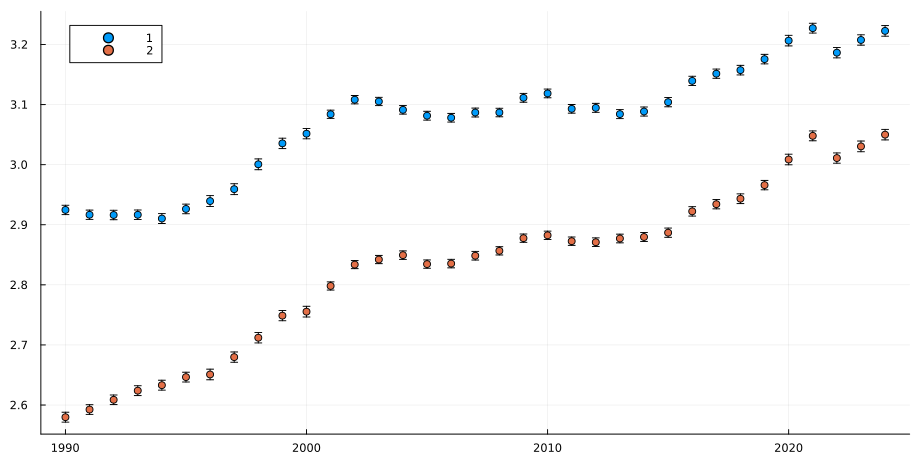

In [4]:
#| code-fold: true
#| echo: true
@chain data begin
  groupby([:YEAR,:SEX])
  @combine begin 
    :m_wage = mean(log.(:WAGE),weights(:ASECWT))
    :v_est = var(log.(:WAGE),weights(:ASECWT)) / length(:WAGE)
    end
  @transform :ci_width = 1.96 * sqrt.(:v_est)
  @df _ scatter(:YEAR,:m_wage,yerror=:ci_width,group=:SEX)
end

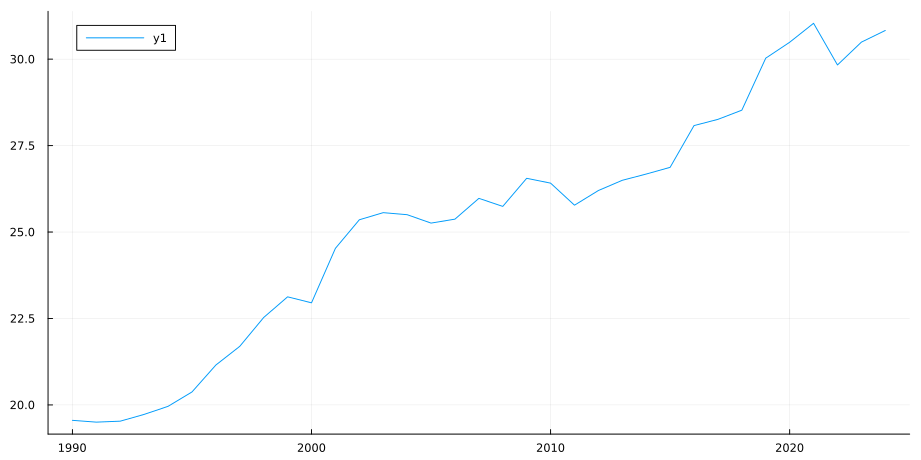

In [5]:
#| echo: true
@chain data begin
    groupby(:YEAR)
    @combine :wage = mean(:WAGE)
    @df _ plot(:YEAR,:wage)
end

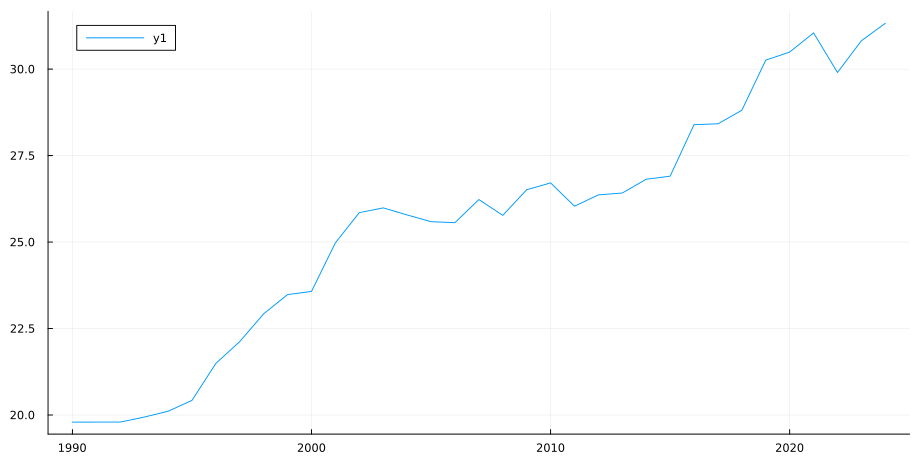

In [6]:
#| echo: true

@chain data begin
    groupby(:YEAR)
    @combine :wage = mean(:WAGE,weights(:ASECWT))
    @df _ plot(:YEAR,:wage)
end

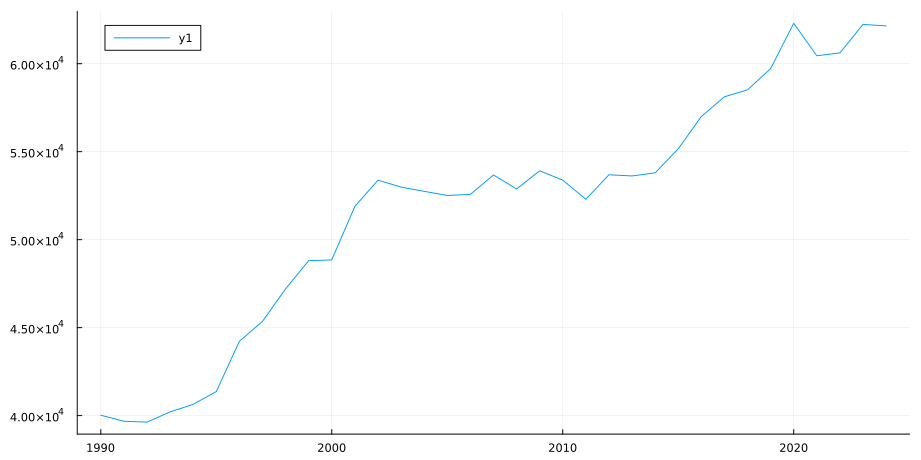

In [7]:
#| echo: true

@chain data begin
    groupby(:YEAR)
    @combine :earn = mean(:INCWAGE,weights(:ASECWT))
    @df _ plot(:YEAR,:earn)
end

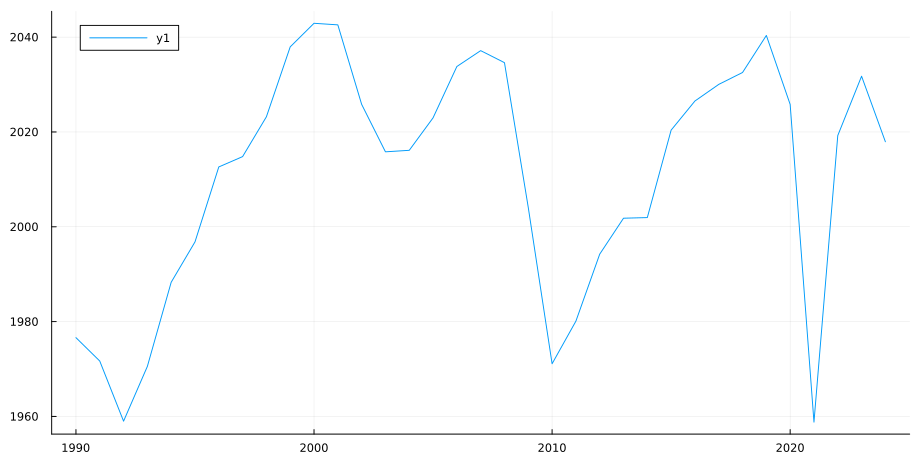

In [8]:
#| echo: true

@chain data begin
    groupby(:YEAR)
    @combine :hours = mean(:HOURS,weights(:ASECWT))
    @df _ plot(:YEAR,:hours)
end

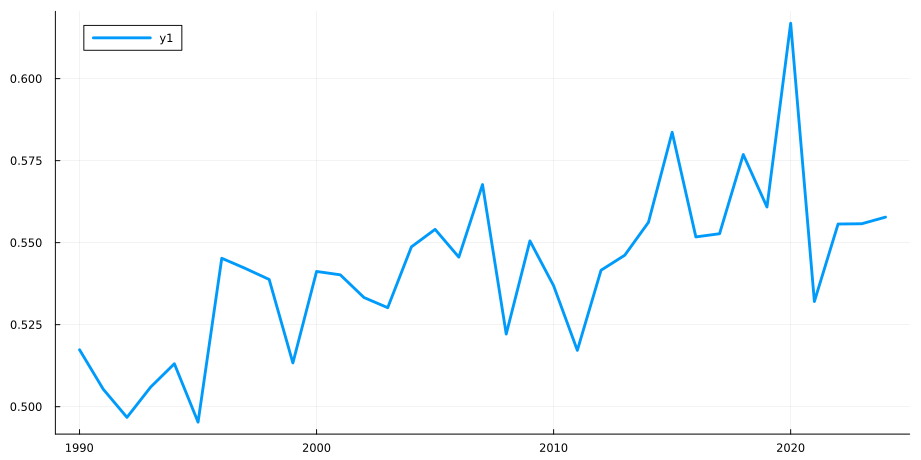

In [9]:
#| echo: true

@chain data begin
    groupby(:YEAR)
    @combine :var_lw = var(log.(:WAGE),weights(:ASECWT))
    @df _ plot(:YEAR,:var_lw,linewidth=3)
end


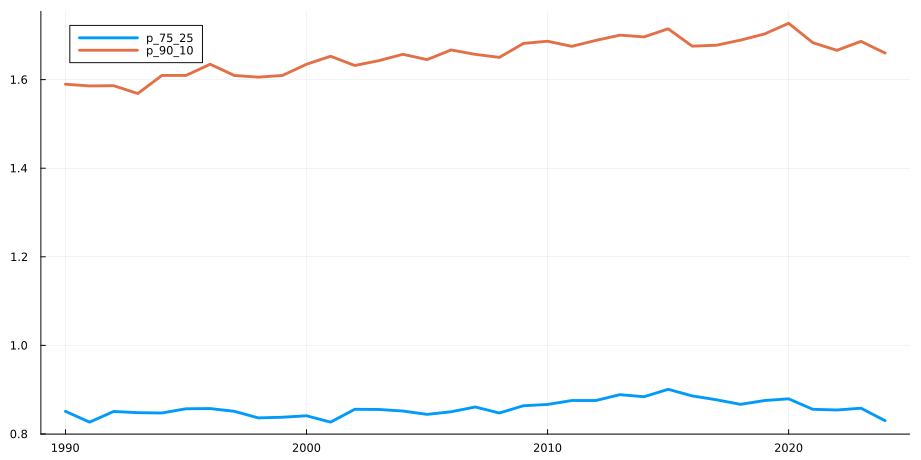

In [10]:
#| code-fold: true
#| echo: true
pctiles = @chain data begin
    groupby(:YEAR)
    @combine begin 
    :p_90_10 = quantile(log.(:WAGE),weights(:ASECWT),0.9) - quantile(log.(:WAGE),weights(:ASECWT),0.1)
    :p_75_25 = quantile(log.(:WAGE),weights(:ASECWT),0.75) - quantile(log.(:WAGE),weights(:ASECWT),0.25)
    end
    stack(Not(:YEAR))
    @df _ plot(:YEAR,:value,group=:variable,linewidth=3)
end

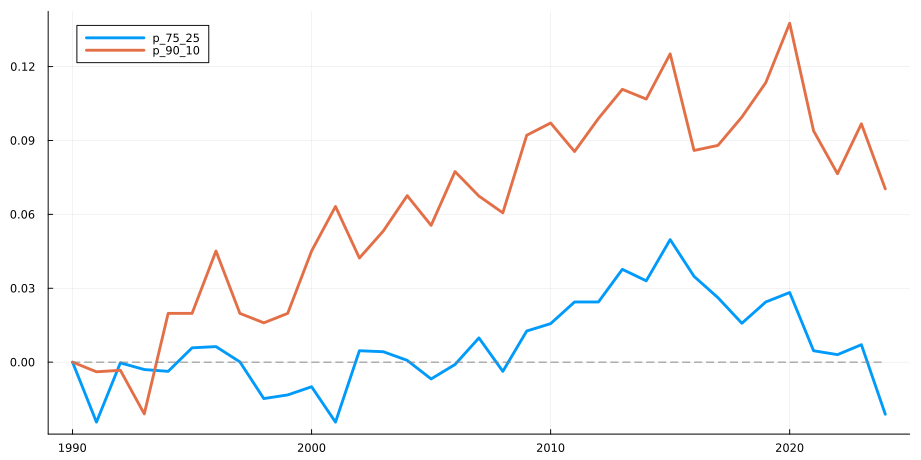

In [11]:
#| code-fold: true
#| echo: true
pctiles = @chain data begin
    groupby(:YEAR)
    @combine begin 
    :p_90_10 = quantile(log.(:WAGE),weights(:ASECWT),0.9) - quantile(log.(:WAGE),weights(:ASECWT),0.1)
    :p_75_25 = quantile(log.(:WAGE),weights(:ASECWT),0.75) - quantile(log.(:WAGE),weights(:ASECWT),0.25)
    end
    stack(Not(:YEAR))
    groupby(:variable)
    @transform :value = :value .- :value[1]
    @df _ plot(:YEAR,:value,group=:variable,linewidth=3)
end
plot!([1990,2024],[0.,0.],linestyle=:dash,color="grey",label=false)

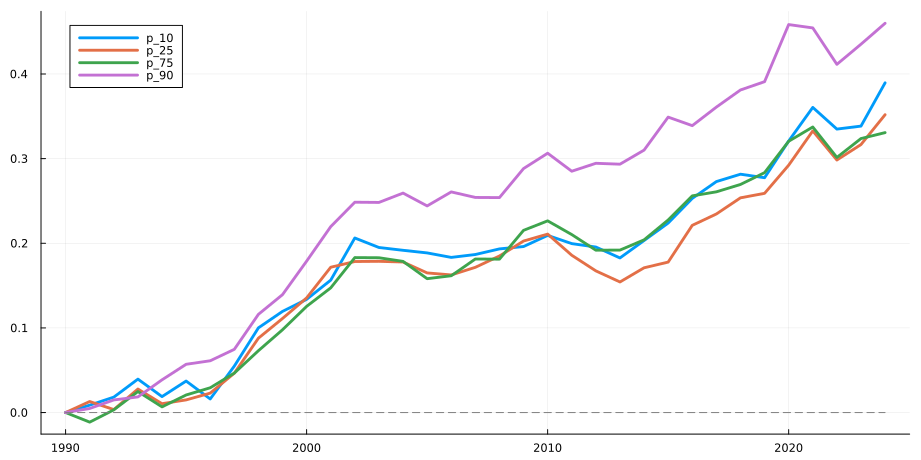

In [12]:
#| code-fold: true
#| echo: true
pctiles = @chain data begin
    groupby(:YEAR)
    @combine begin 
    :p_90 = quantile(log.(:WAGE),weights(:ASECWT),0.9)
    :p_10 = quantile(log.(:WAGE),weights(:ASECWT),0.1)
    :p_75 = quantile(log.(:WAGE),weights(:ASECWT),0.75)
    :p_25 = quantile(log.(:WAGE),weights(:ASECWT),0.25)
    end
    stack(Not(:YEAR))
    groupby(:variable)
    @transform :value = :value .- :value[1]
    @df _ plot(:YEAR,:value,group=:variable,linewidth=3)
end
plot!([1990,2024],[0.,0.],linestyle=:dash,color="grey",label=false)

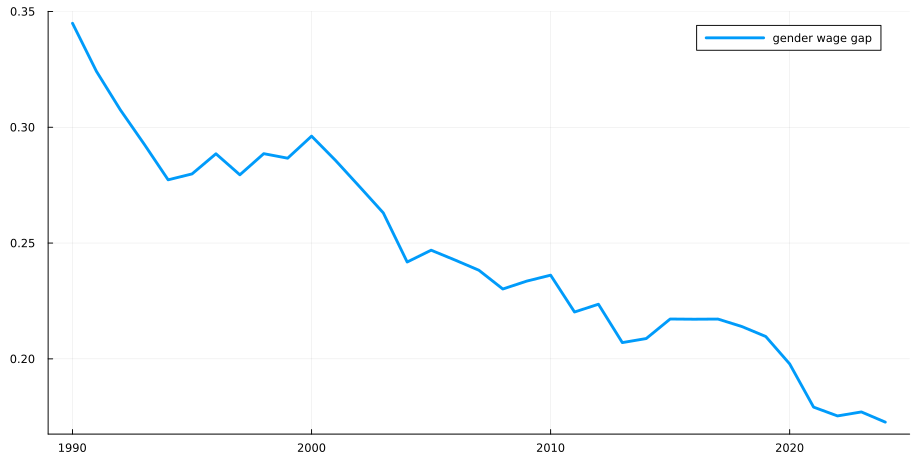

In [13]:
#| code-fold: true
#| echo: true
#| code-line-numbers: 2-3|4|5|6

@chain data begin
  groupby([:YEAR,:SEX])
  @combine :m_wage = mean(log.(:WAGE),weights(:ASECWT))
  unstack(:YEAR,:SEX,:m_wage,renamecols=x->Symbol(:wage_, x))
  @transform :gender_gap = :wage_1 .- :wage_2
  @df _ plot(:YEAR,:gender_gap,label = "gender wage gap",linewidth=3.)
end

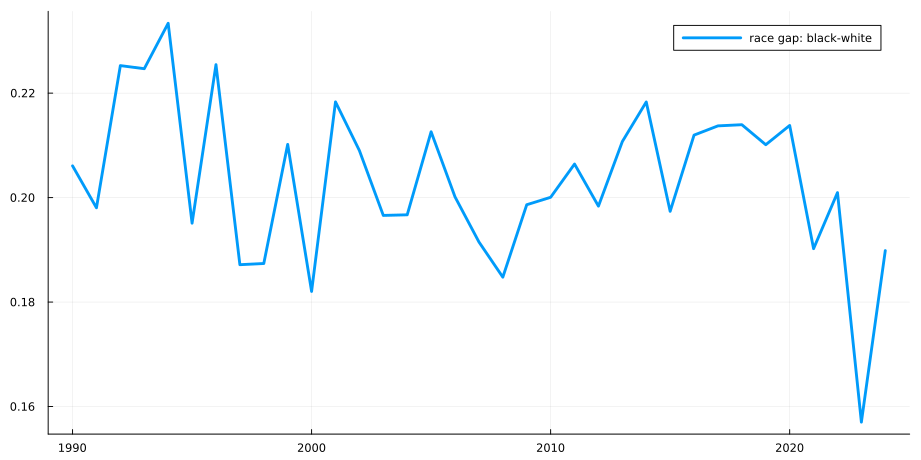

In [14]:
#| code-fold: true
#| echo: true

@chain data begin
  groupby([:YEAR,:RACE])
  @combine :m_wage = mean(log.(:WAGE),weights(:ASECWT))
  unstack(:YEAR,:RACE,:m_wage,renamecols=x->Symbol(:wage_, x))
  @transform :black_white_gap = :wage_100 .- :wage_200
  @df _ plot(:YEAR,:black_white_gap,label = "race gap: black-white",linewidth=3.)
end

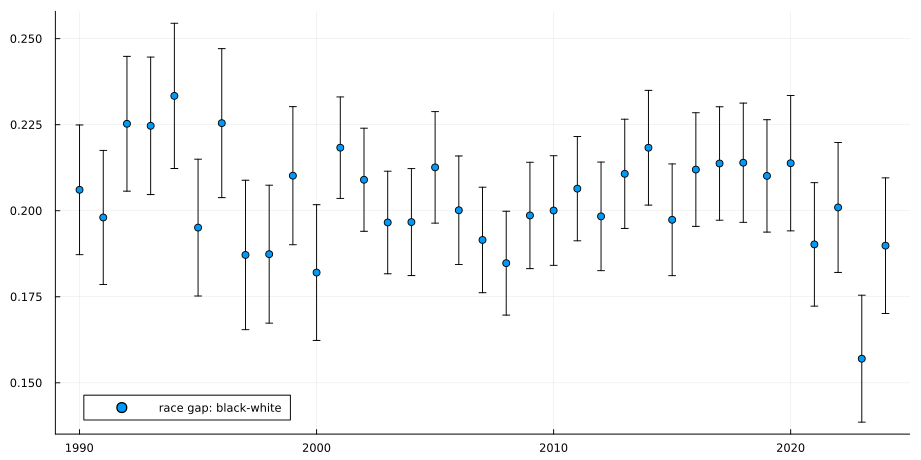

In [15]:
#| code-fold: true
#| echo: true
#| code-line-numbers:  5-6|8|9-10|12-13

@chain data begin
  @subset :RACE .<= 200
  groupby([:YEAR,:RACE])
  @combine begin 
    :m_wage = mean(log.(:WAGE),weights(:ASECWT))
    :v_est = var(log.(:WAGE),weights(:ASECWT)) / length(:WAGE)
  end
  stack()
  @transform :variable = string.(:variable,"_",:RACE)
  unstack(:YEAR,:variable,:value)
  @transform begin
    :black_white_gap = :m_wage_100 .- :m_wage_200
    :std_err = 1.96*sqrt.(:v_est_100 .+ :v_est_200)
  end
  @df _ scatter(:YEAR,:black_white_gap,yerror = :std_err,label = "race gap: black-white")
end

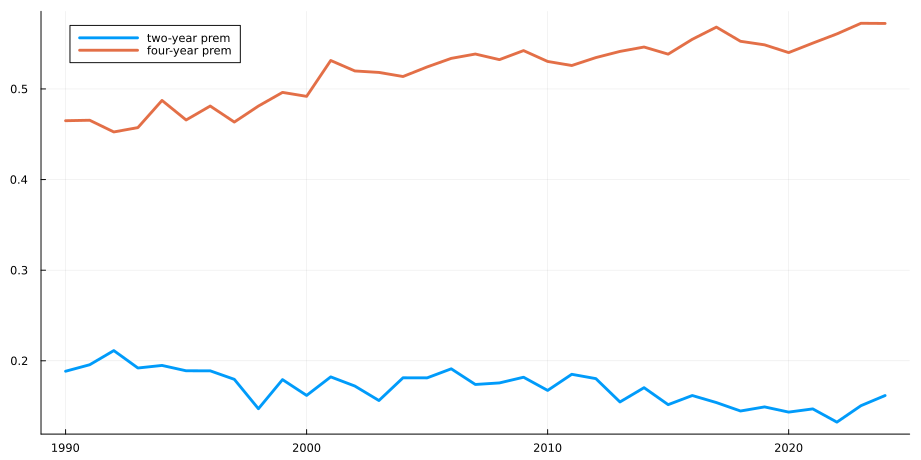

In [16]:
#| code-fold: true
#| echo: true
#| code-line-numbers:  2|8

@chain data begin
  @transform :educ = (:EDUC.>=70) .+ (:EDUC.>=90) .+ (:EDUC.>=110)
  groupby([:YEAR,:educ])
  @combine begin 
    :m_wage = mean(log.(:WAGE),weights(:ASECWT))
  end
  unstack(:YEAR,:educ,:m_wage,renamecols=x->Symbol(:wage_, x))
  @transform :two_yr = :wage_2 .- :wage_1 :four_yr = :wage_3 .- :wage_1
  @df _ begin
    plot(:YEAR,:two_yr,label="two-year prem",linewidth=3)
    plot!(:YEAR,:four_yr,label="four-year prem",linewidth=3)
  end
end

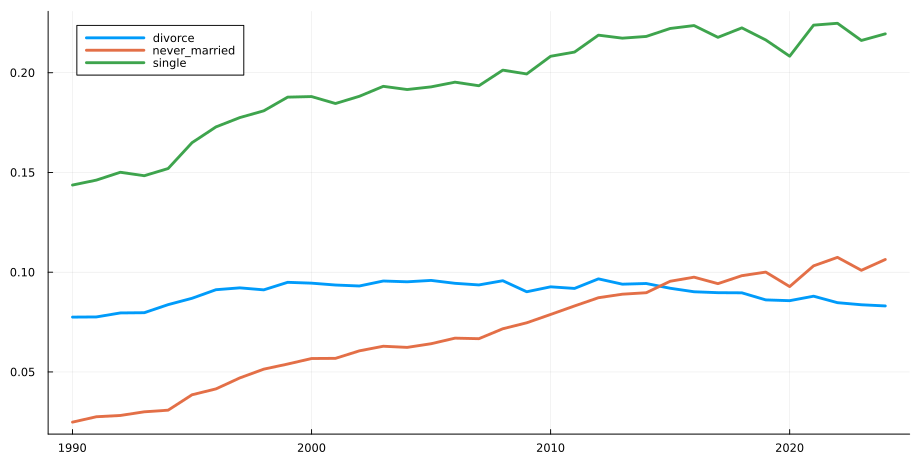

In [17]:
#| code-fold: true
#| echo: true
#| code-line-numbers:  2|4-6

test = @chain data begin
  @subset :NCHILD.>0
  groupby(:YEAR)
  @combine begin
    :divorce = mean(:MARST.==4)
    :never_married = mean(:MARST.==6)
    :single = mean(:MARST.>2)
  end
  stack(Not(:YEAR))
  @df _ plot(:YEAR,:value,group=:variable,linewidth=3)
end

In [18]:
#| echo: true
#| code-line-numbers:  2|3-4

v_w = @chain data begin
  @transform :cohort = Int.(round.((:YEAR .- :AGE) ./ 10) .* 10)
  groupby([:cohort,:AGE])
  @combine :var_logw = var(log.(:WAGE),weights(:ASECWT))
end

Row,cohort,AGE,var_logw
,Int64,Int64,Float64
1,1930,56,0.617128
2,1930,57,0.555906
3,1930,58,0.526267
4,1930,59,0.595774
5,1930,60,0.602591
6,1930,61,0.635663
7,1930,62,0.626394
8,1930,63,0.715607
9,1930,64,0.710725


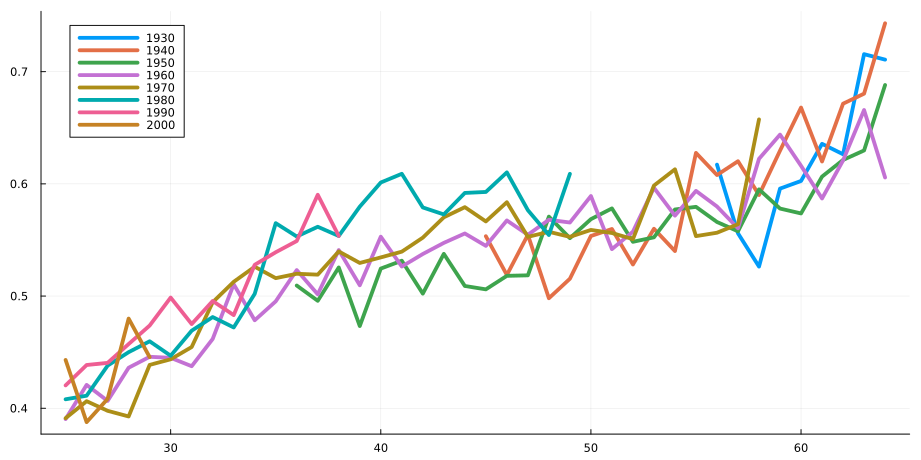

In [19]:
@df v_w plot(:AGE,:var_logw,group=:cohort,linewidth=4)